In [16]:
import torch
print(torch.cuda.is_available())

True


In [17]:
import numpy as np
import pandas as pd
import torch
import os
import argparse
from tqdm import tqdm
from rdkit import RDLogger, Chem
from rdkit.Chem import Draw
import yaml

from seq_graph_retro.utils.parse import get_reaction_info, extract_leaving_groups
from seq_graph_retro.utils.chem import apply_edits_to_mol
from seq_graph_retro.utils.edit_mol import canonicalize, generate_reac_set
from seq_graph_retro.models import EditLGSeparate
from seq_graph_retro.search import BeamSearch
from seq_graph_retro.molgraph import MultiElement
lg = RDLogger.logger()
lg.setLevel(4)


In [18]:
try:
    ROOT_DIR = os.environ["SEQ_GRAPH_RETRO"]    #/home/wuhexing/GraphRetro
    DATA_DIR = os.path.join(ROOT_DIR, "datasets", "uspto-50k")
    EXP_DIR = os.path.join(ROOT_DIR, "models")

except KeyError:
    ROOT_DIR = "./"
    DATA_DIR = os.path.join(ROOT_DIR, "datasets", "uspto-50k")
    EXP_DIR = os.path.join(ROOT_DIR, "local_experiments")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEFAULT_TEST_FILE = f"{DATA_DIR}/canonicalized_test.csv"

In [19]:
def canonicalize_prod(p):
    pcanon = canonicalize(p)
    pmol = Chem.MolFromSmiles(pcanon)
    [atom.SetAtomMapNum(atom.GetIdx()+1) for atom in pmol.GetAtoms()]
    p = Chem.MolToSmiles(pmol)
    return p

def load_edits_model(args):
    edits_step = args.edits_step
    if edits_step is None:
        edits_step = "best_model"

    if "run" in args.edits_exp:
        # This addition because some of the new experiments were run using wandb
        edits_loaded = torch.load(os.path.join(args.exp_dir, "wandb", args.edits_exp, "files", edits_step + ".pt"), map_location=DEVICE)
        with open(f"{args.exp_dir}/wandb/{args.edits_exp}/files/config.yaml", "r") as f:
            tmp_loaded = yaml.load(f, Loader=yaml.FullLoader)

        model_name = tmp_loaded['model']['value']

    else:
        edits_loaded = torch.load(os.path.join(args.exp_dir, args.edits_exp,
                                  "checkpoints", edits_step + ".pt"),
                                  map_location=DEVICE)
        model_name = args.edits_exp.split("_")[0]

    return edits_loaded, model_name

def load_lg_model(args):
    lg_step = args.lg_step
    if lg_step is None:
        lg_step = "best_model"

    if "run" in args.lg_exp:
        # This addition because some of the new experiments were run using wandb
        lg_loaded = torch.load(os.path.join(args.exp_dir, "wandb", args.lg_exp, "files", lg_step + ".pt"), map_location=DEVICE)
        with open(f"{args.exp_dir}/wandb/{args.lg_exp}/files/config.yaml", "r") as f:
            tmp_loaded = yaml.load(f, Loader=yaml.FullLoader)

        model_name = tmp_loaded['model']['value']

    else:
        lg_loaded = torch.load(os.path.join(args.exp_dir, args.lg_exp,
                               "checkpoints", lg_step + ".pt"),
                                map_location=DEVICE)
        model_name = args.lg_exp.split("_")[0]

    return lg_loaded, model_name

In [20]:
parser = argparse.ArgumentParser()
parser.add_argument("--data_dir", default=DATA_DIR, help="Data directory")
parser.add_argument("--exp_dir", default=EXP_DIR, help="Experiments directory.")
parser.add_argument("--test_file", default=DEFAULT_TEST_FILE, help="Test file.")
parser.add_argument("--edits_exp", default="SingleEdit_10-02-2021--08-44-37",help="Name of edit prediction experiment.")
parser.add_argument("--edits_step", default="epoch_156",help="Checkpoint for edit prediction experiment.")
parser.add_argument("--lg_exp", default="LGIndEmbed_18-02-2021--12-23-26",help="Name of synthon completion experiment.")
parser.add_argument("--lg_step", default="step_101951",help="Checkpoint for synthon completion experiment.")
parser.add_argument("--beam_width", default=10, type=int, help="Beam width")
parser.add_argument("--use_rxn_class", action='store_true', help="Whether to use reaction class.")
parser.add_argument("--rxn_class_acc", action="store_true",help="Whether to print reaction class accuracy.")
args, unknown = parser.parse_known_args()   #用一个unknown忽略不认识的参数
test_df = pd.read_csv(args.test_file)    #读入测试文件

edits_loaded, edit_net_name = load_edits_model(args)    #加载图编辑预测模型
lg_loaded, lg_net_name = load_lg_model(args)            #加载离去基团选择模型



/tmp/ipykernel_800801/835237206.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  edits_loaded = torch.load(os.path.join(args.exp_dir, args.edits_exp,
/tmp/ipykernel_8008

In [21]:
#打印模型参数
edits_config = edits_loaded["saveables"]
lg_config = lg_loaded['saveables']
lg_toggles = lg_config['toggles']

print(edits_config)
print(lg_config)
print(lg_toggles)

if 'tensor_file' in lg_config:  #这里是false
    if not os.path.isfile(lg_config['tensor_file']):
        if not lg_toggles.get("use_rxn_class", False):
            tensor_file = os.path.join(args.data_dir, "train/h_labels/without_rxn/lg_inputs.pt")
        else:
            tensor_file = os.path.join(args.data_dir, "train/h_labels/with_rxn/lg_inputs.pt")
        lg_config['tensor_file'] = tensor_file


{'config': {'n_atom_feat': 98, 'n_bond_feat': 6, 'n_bin_feat': 11, 'rnn_type': 'gru', 'mpn_size': 256, 'mlp_size': 512, 'depth': 10, 'bias': False, 'edit_loss': 'sigmoid', 'bs_outdim': 5, 'bond_label_feat': 109, 'dropout_mlp': 0.3, 'dropout_mpn': 0.15, 'pos_weight': 5.0}, 'encoder_name': 'GraphFeatEncoder', 'toggles': {'use_attn': False, 'use_h_labels': True, 'use_prod': True, 'use_nei': False, 'propagate_logits': True}}
{'config': {'rnn_type': 'gru', 'mpn_size': 300, 'mlp_size': 300, 'depth': 10, 'bias': False, 'embed_size': 200, 'dropout_mlp': 0.3, 'dropout_mpn': 0.15, 'n_mt_blocks': 2, 'n_atom_feat': 98, 'n_bond_feat': 6, 'n_heads': 4, 'embed_bias': False}, 'lg_vocab': <seq_graph_retro.molgraph.vocab.Vocab object at 0x74be6df1b160>, 'encoder_name': 'GraphFeatEncoder', 'toggles': {'use_attn': False, 'use_prev_pred': True, 'use_rxn_class': False}}
{'use_attn': False, 'use_prev_pred': True, 'use_rxn_class': False}


In [22]:
rm = EditLGSeparate(edits_config=edits_config, lg_config=lg_config, edit_net_name=edit_net_name,
                        lg_net_name=lg_net_name, device=DEVICE)
rm.load_state_dict(edits_loaded['state'], lg_loaded['state'])
rm.to(DEVICE)
rm.eval()   #设置模型为评估模式

n_matched = np.zeros(args.beam_width)   #beam_size,默认为10

beam_model = BeamSearch(model=rm, beam_width=args.beam_width, max_edits=1)
# pbar = tqdm(list(range(len(test_df))))
pbar = tqdm(list(range(5)))


  0%|          | 0/5 [00:00<?, ?it/s]

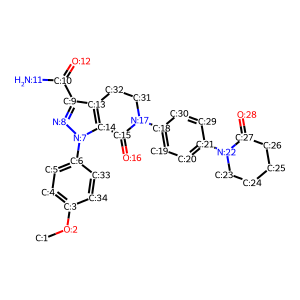

0 图编辑网络的预测结果： 21:22:1.0:0.0   离去基团的标签预测结果 ['[Br:1]', '<eos>']
{'O=C1CCCCN1', 'COc1ccc(-n2nc(C(N)=O)c3c2C(=O)N(c2ccc(Br)cc2)CC3)cc1'}
1 图编辑网络的预测结果： 10:11:1.0:0.0   离去基团的标签预测结果 ['[OH:1]', '<eos>']
{'N', 'COc1ccc(-n2nc(C(=O)O)c3c2C(=O)N(c2ccc(N4CCCCC4=O)cc2)CC3)cc1'}
2 图编辑网络的预测结果： 22:23:1.0:0.0   离去基团的标签预测结果 ['[Cl:1]']
{'CCCCC(=O)N(Cl)c1ccc(N2CCc3c(C(N)=O)nn(-c4ccc(OC)cc4)c3C2=O)cc1'}
3 图编辑网络的预测结果： 22:23:1.0:0.0   离去基团的标签预测结果 ['[Cl:1]']
{'CCCCC(=O)N(Cl)c1ccc(N2CCc3c(C(N)=O)nn(-c4ccc(OC)cc4)c3C2=O)cc1'}
4 图编辑网络的预测结果： 22:23:1.0:0.0   离去基团的标签预测结果 ['[Cl:1]']
{'CCCCC(=O)N(Cl)c1ccc(N2CCc3c(C(N)=O)nn(-c4ccc(OC)cc4)c3C2=O)cc1'}
5 图编辑网络的预测结果： 22:23:1.0:0.0   离去基团的标签预测结果 ['[Cl:1]']
{'CCCCC(=O)N(Cl)c1ccc(N2CCc3c(C(N)=O)nn(-c4ccc(OC)cc4)c3C2=O)cc1'}
6 图编辑网络的预测结果： 22:23:1.0:0.0   离去基团的标签预测结果 ['[Cl:1]']
{'CCCCC(=O)N(Cl)c1ccc(N2CCc3c(C(N)=O)nn(-c4ccc(OC)cc4)c3C2=O)cc1'}
7 图编辑网络的预测结果： 22:23:1.0:0.0   离去基团的标签预测结果 ['[Cl:1]']
{'CCCCC(=O)N(Cl)c1ccc(N2CCc3c(C(N)=O)nn(-c4ccc(OC)cc4)c3C2=O)cc1'}
8 图编辑网络的预测结果： 2

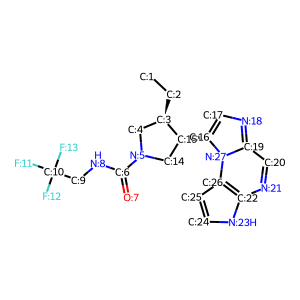

0 图编辑网络的预测结果： 6:8:1.0:0.0   离去基团的标签预测结果 ['[Cl:1]', '<eos>']
{'CC[C@@H]1CN(C(=O)Cl)C[C@@H]1c1cnc2cnc3[nH]ccc3n12', 'NCC(F)(F)F'}
1 图编辑网络的预测结果： 5:6:1.0:0.0   离去基团的标签预测结果 ['<eos>', '[Cl:1]']
{'CC[C@@H]1CNC[C@@H]1c1cnc2cnc3[nH]ccc3n12', 'O=C(Cl)NCC(F)(F)F'}
2 图编辑网络的预测结果： 15:16:1.0:0.0   离去基团的标签预测结果 ['[OH:1]', '<eos>']
{'CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@H]1O', 'c1cn2c(cnc3[nH]ccc32)n1'}
3 图编辑网络的预测结果： 15:16:1.0:0.0   离去基团的标签预测结果 ['[O:1]', '<eos>']
{'c1cn2c(cnc3[nH]ccc32)n1', 'CC[C@@H]1CN(C(=O)NCC(F)(F)F)CC1=O'}
4 图编辑网络的预测结果： 15:16:1.0:0.0   离去基团的标签预测结果 ['CS(=O)(=O)[O:1]', '<eos>']
{'CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@H]1OS(C)(=O)=O', 'c1cn2c(cnc3[nH]ccc32)n1'}
5 图编辑网络的预测结果： 16:27:1.5:0.0   离去基团的标签预测结果 ['[O:1]']
set()
6 图编辑网络的预测结果： 16:27:1.5:0.0   离去基团的标签预测结果 ['[O:1]']
set()
7 图编辑网络的预测结果： 16:27:1.5:0.0   离去基团的标签预测结果 ['[O:1]']
set()
8 图编辑网络的预测结果： 16:27:1.5:0.0   离去基团的标签预测结果 ['[O:1]']
set()
9 图编辑网络的预测结果： 16:27:1.5:0.0   离去基团的标签预测结果 ['[O:1]']
set()


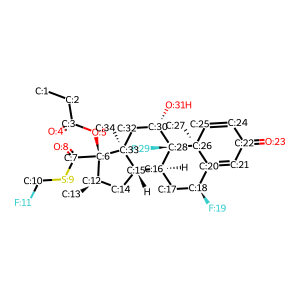

0 图编辑网络的预测结果： 31:0:1.0:0.0   离去基团的标签预测结果 ['C[C:1]=O']
{'CCC(=O)O[C@]1(C(=O)SCF)[C@H](C)C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](OC(C)=O)C[C@@]21C'}
1 图编辑网络的预测结果： 31:0:1.0:0.0   离去基团的标签预测结果 ['C[C:1]=O']
{'CCC(=O)O[C@]1(C(=O)SCF)[C@H](C)C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](OC(C)=O)C[C@@]21C'}
2 图编辑网络的预测结果： 31:0:1.0:0.0   离去基团的标签预测结果 ['C[C:1]=O']
{'CCC(=O)O[C@]1(C(=O)SCF)[C@H](C)C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](OC(C)=O)C[C@@]21C'}
3 图编辑网络的预测结果： 31:0:1.0:0.0   离去基团的标签预测结果 ['C[C:1]=O']
{'CCC(=O)O[C@]1(C(=O)SCF)[C@H](C)C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](OC(C)=O)C[C@@]21C'}
4 图编辑网络的预测结果： 31:0:1.0:0.0   离去基团的标签预测结果 ['C[C:1]=O']
{'CCC(=O)O[C@]1(C(=O)SCF)[C@H](C)C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](OC(C)=O)C[C@@]21C'}
5 图编辑网络的预测结果： 31:0:1.0:0.0   离去基团的标签预测结果 ['C[C:1]=O']
{'CCC(=O)O[C@]1(C(=O)SCF)[C@H](C)C[C@H]2[C@@H]3C[C@H](F)C4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](OC(C)=O)C[C@@]21C'}
6 图编

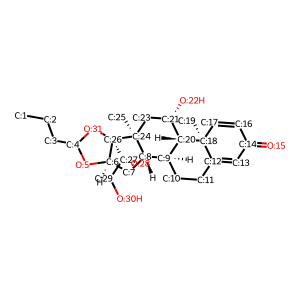

0 图编辑网络的预测结果： 30:0:1.0:0.0   离去基团的标签预测结果 ['C[C:1]=O']
{'CCCC1O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(=O)COC(C)=O)O1'}
1 图编辑网络的预测结果： 22:0:1.0:0.0   离去基团的标签预测结果 ['C[C:1]=O']
{'CCCC1O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H](OC(C)=O)C[C@]3(C)[C@]2(C(=O)CO)O1'}
2 图编辑网络的预测结果： 27:28:2.0:1.0   离去基团的标签预测结果 ['<eos>']
{'CCCC1O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(O)CO)O1'}
3 图编辑网络的预测结果： 30:0:1.0:0.0   离去基团的标签预测结果 ['[F:1]']
{'CCCC1O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(=O)COF)O1'}
4 图编辑网络的预测结果： 21:22:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CCCC1O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4C(=O)C[C@]3(C)[C@]2(C(=O)CO)O1'}
5 图编辑网络的预测结果： 14:15:2.0:1.0   离去基团的标签预测结果 ['<eos>']
{'CCCC1O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(O)C=C[C@]5(C)[C@H]4[C@@H](O)C[C@]3(C)[C@]2(C(=O)CO)O1'}
6 图编辑网络的预测结果： 30:0:1.0:0.0   离去基团的标签预测结果 ['[Cl:1]']
{'CCCC1O[C@@H]2C[C@H]3[C@@H]4CCC5=CC(=O)C=C[C@]5(C)[C@H]4[C@@H

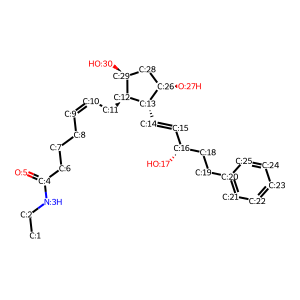

0 图编辑网络的预测结果： 16:17:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CCNC(=O)CCC/C=C\\C[C@@H]1[C@@H](/C=C/C(=O)CCc2ccccc2)[C@H](O)C[C@@H]1O'}
1 图编辑网络的预测结果： 16:17:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CCNC(=O)CCC/C=C\\C[C@@H]1[C@@H](/C=C/C(=O)CCc2ccccc2)[C@H](O)C[C@@H]1O'}
2 图编辑网络的预测结果： 16:17:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CCNC(=O)CCC/C=C\\C[C@@H]1[C@@H](/C=C/C(=O)CCc2ccccc2)[C@H](O)C[C@@H]1O'}
3 图编辑网络的预测结果： 16:17:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CCNC(=O)CCC/C=C\\C[C@@H]1[C@@H](/C=C/C(=O)CCc2ccccc2)[C@H](O)C[C@@H]1O'}
4 图编辑网络的预测结果： 16:17:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CCNC(=O)CCC/C=C\\C[C@@H]1[C@@H](/C=C/C(=O)CCc2ccccc2)[C@H](O)C[C@@H]1O'}
5 图编辑网络的预测结果： 16:17:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CCNC(=O)CCC/C=C\\C[C@@H]1[C@@H](/C=C/C(=O)CCc2ccccc2)[C@H](O)C[C@@H]1O'}
6 图编辑网络的预测结果： 16:17:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CCNC(=O)CCC/C=C\\C[C@@H]1[C@@H](/C=C/C(=O)CCc2ccccc2)[C@H](O)C[C@@H]1O'}
7 图编辑网络的预测结果： 16:17:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CCNC(=O)CCC/C=C\\C[C@@H]1[C@@H](/C=C/C(=O)CCc2ccccc2)[C@H

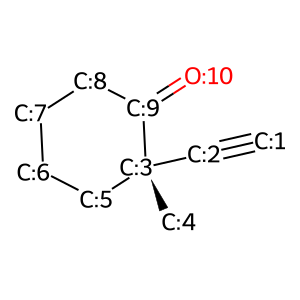

0 图编辑网络的预测结果： 1:0:1.0:0.0   离去基团的标签预测结果 ['C[Si:1](C)C']
{'C[C@@]1(C#C[Si](C)(C)C)CCCCC1=O'}
1 图编辑网络的预测结果： 1:0:1.0:0.0   离去基团的标签预测结果 ['CO[C:1]=O']
{'COC(=O)C#C[C@]1(C)CCCCC1=O'}
2 图编辑网络的预测结果： 8:0:1.0:0.0   离去基团的标签预测结果 ['C[Si:1](C)C']
{'C#C[C@]1(C)CCCC([Si](C)(C)C)C1=O'}
3 图编辑网络的预测结果： 8:0:1.0:0.0   离去基团的标签预测结果 ['CO[C:1]=O']
{'C#C[C@]1(C)CCCC(C(=O)OC)C1=O'}
4 图编辑网络的预测结果： 1:0:1.0:0.0   离去基团的标签预测结果 ['CC(C)(C)O[C:1]=O']
{'CC(C)(C)OC(=O)C#C[C@]1(C)CCCCC1=O'}
5 图编辑网络的预测结果： 9:10:2.0:1.0   离去基团的标签预测结果 ['<eos>']
{'C#C[C@]1(C)CCCCC1O'}
6 图编辑网络的预测结果： 8:0:1.0:0.0   离去基团的标签预测结果 ['CC(C)(C)O[C:1]=O']
{'C#C[C@]1(C)CCCC(C(=O)OC(C)(C)C)C1=O'}
7 图编辑网络的预测结果： 7:8:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'C#C[C@]1(C)CCC=CC1=O'}
8 图编辑网络的预测结果： 1:0:1.0:0.0   离去基团的标签预测结果 ['[Br:1].[Br:1]']
set()
9 图编辑网络的预测结果： 1:0:1.0:0.0   离去基团的标签预测结果 ['CCO[C:1]=O']
{'CCOC(=O)C#C[C@]1(C)CCCCC1=O'}


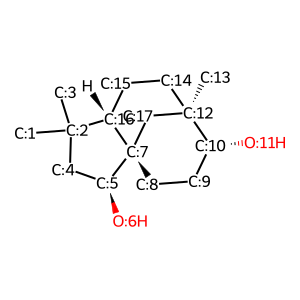

0 图编辑网络的预测结果： 10:11:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CC1(C)C[C@H](O)[C@]23CCC(=O)[C@](C)(CC[C@@H]12)C3'}
1 图编辑网络的预测结果： 5:6:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CC1(C)CC(=O)[C@]23CC[C@@H](O)[C@](C)(CC[C@@H]12)C3'}
2 图编辑网络的预测结果： 6:0:1.0:0.0   离去基团的标签预测结果 ['C[C:1]=O']
{'CC(=O)O[C@H]1CC(C)(C)[C@@H]2CC[C@]3(C)C[C@]12CC[C@H]3O'}
3 图编辑网络的预测结果： 11:0:1.0:0.0   离去基团的标签预测结果 ['C[C:1]=O']
{'CC(=O)O[C@@H]1CC[C@]23C[C@@]1(C)CC[C@H]2C(C)(C)C[C@@H]3O'}
4 图编辑网络的预测结果： 14:15:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CC1(C)C[C@H](O)[C@]23CC[C@@H](O)[C@](C)(C=C[C@@H]12)C3'}
5 图编辑网络的预测结果： 8:9:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CC1(C)C[C@H](O)[C@]23C=C[C@@H](O)[C@](C)(CC[C@@H]12)C3'}
6 图编辑网络的预测结果： 4:5:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CC1(C)C=C(O)[C@]23CC[C@@H](O)[C@](C)(CC[C@@H]12)C3'}
7 图编辑网络的预测结果： 9:10:1.0:2.0   离去基团的标签预测结果 ['<eos>']
{'CC1(C)C[C@H](O)[C@]23CC=C(O)[C@](C)(CC[C@@H]12)C3'}
8 图编辑网络的预测结果： 6:0:1.0:0.0   离去基团的标签预测结果 ['c1ccc([CH2:1])cc1']
{'CC1(C)C[C@H](OCc2ccccc2)[C@]23CC[C@@H](O)[C@](C)(CC[C@@H]12)C3'}
9 图

In [26]:
smiles=['COC1=CC=C(N2N=C(C3=C2C(N(C4=CC=C(N5CCCCC5=O)C=C4)CC3)=O)C(N)=O)C=C1',
    'CC[C@H](CN(C(NCC(F)(F)F)=O)C1)[C@H]1C2=CN=C3C=NC4=C(C=CN4)N32',
    'C[C@@]12[C@@](C(SCF)=O)([C@@H](C[C@]1([C@@]3(C[C@@H](C4=CC(C=C[C@@]4([C@]3([C@H](C2)O)F)C)=O)F)[H])[H])C)OC(CC)=O',
    '[H][C@@]12C[C@H]3OC(O[C@]3([C@]1(C[C@@H]([C@]4([C@]2(CCC5=CC(C=C[C@]45C)=O)[H])[H])O)C)C(CO)=O)CCC',
    'CCNC(=O)CCC/C=C\C[C@H]1[C@H](C[C@H]([C@@H]1/C=C/[C@H](CCC2=CC=CC=C2)O)O)O',
    'O=C1[C@@](C#C)(C)CCCC1',
    'O[C@@H]1CC[C@@](C2)([C@@H](O)CC3(C)C)[C@H]3CC[C@]21C']

for smile in smiles:
    p = canonicalize_prod(smile)
    mol=Chem.MolFromSmiles(p)
    img = Draw.MolToImage(mol)
    display(img)
    top_k_nodes = beam_model.run_search(p, max_steps=6) #进行束搜索，beam_size=10
    for beam_idx, node in enumerate(top_k_nodes):
        pred_edit = node.edit
        pred_label = node.lg_groups

        if isinstance(pred_edit, list): #检查pre_edit是否为一个列表，如果是，执行下面语句
            pred_edit = pred_edit[0]
        # edits: Iterable[str],
        # Iterable of edits to apply. An edit is structured as a1:a2:b1:b2, where
        # a1, a2 are atom maps of participating atoms and b1, b2 are previous and
        # new bond orders. When  a2 = 0, we update the hydrogen count.
        print(beam_idx,"图编辑网络的预测结果：",pred_edit,"  离去基团的标签预测结果",pred_label)

        try:
            pred_set = generate_reac_set(p, pred_edit, pred_label, verbose=False)
        except BaseException as e:
            print(e, flush=True)
            pred_set = None
        print(pred_set)

